In [142]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import scipy.signal as sgn
import pickle
import os
import warnings
import quail as q
import hypertools as hyp
import future

from glob import glob
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.interpolate import pchip
from scipy.signal import find_peaks as localmax

%matplotlib inline

## Set path, load sherlock video and recall trajectories, load free recall data

In [1046]:
datadir = '../../../data/'
figdir = '../../../figs/'
video_model, recall_models = np.load(os.path.join(datadir, 'processed', 'models_t100_v50_r10.npy'))
fr_random_data = q.load_egg(os.path.join(datadir, 'free recall', 'exp1.egg'))
fr_cat_data = q.load_egg(os.path.join(datadir, 'free recall', 'exp2.egg'))

## Plot figure

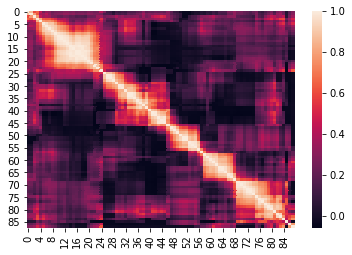

In [1045]:
h = sns.heatmap(pd.DataFrame(recall_models[0]).T.corr())

In [22]:
def parse_diag(M):
    n = M.shape[1]
    x = np.nan * np.zeros([M.shape[0], 2 * n + 1])
    
    for i in np.arange(n):
        x[i, (n - i):n] = M[i, 0:i]
        x[i, n] = M[i, i]
        x[i, (n+1):(n + n - i)] = M[i, (i+1):]
    
    return pd.DataFrame(x, columns=np.arange(-n, n+1))

In [23]:
M = pd.DataFrame(recall_models[0]).T.corr().values
np.fill_diagonal(M, np.nan)
x = parse_diag(M)

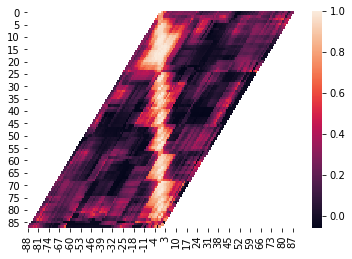

In [24]:
h = sns.heatmap(x)

In [743]:
def plot_ribbon(x, color='k', ribbon_alpha=0.2):
    mean = x.mean()
    ci = 1.96 * np.divide(x.std(), np.sqrt(x.shape[0]))
    
    xvals = x.columns
    h = plt.gcf()
    plt.fill_between(xvals, mean - ci, mean + ci, color=color, alpha=ribbon_alpha)
    plt.plot(xvals, mean, color=color)
    
    return h

def resample(x, axis=0, nbins=100):
    if not (type(x) is pd.DataFrame):
        x = pd.DataFrame(x)
    
    if type(axis) is list:
        if len(axis) == 0:
            return x
        else:
            if not(type(nbins) is list):
                nbins = [nbins] * len(axis)
            x = resample(x, axis[0], nbins=nbins[0])
            for i in np.arange(1, len(axis)):
                x = resample(x, axis[i], nbins=nbins[i])
            return x
    
    if axis == 1:
        return resample(x.T, axis=0, nbins=nbins).T
    elif not (axis == 0):
        raise Exception('resampling must be along axis 0 or 1')
    
    vals = np.array(x.axes[axis])
    minval = np.min(vals)
    maxval = np.max(vals)
    
    newvals = np.linspace(minval, maxval, nbins)
    normed_newvals = np.divide(newvals, np.max([np.abs(minval), np.abs(maxval)]))    
    
    y = np.zeros([nbins, x.shape[1]])
    for i in np.arange(x.shape[1]):
        y[:, i] = pchip(vals, x.iloc[:, i], extrapolate=False)(newvals)
    
    return pd.DataFrame(y, index=normed_newvals, columns=x.columns)

def autocorr_plot(r, color='k', res=False, nbins=101, pass_matrix=False, show_plot=True):
    if pass_matrix:
        M = r
    else:
        M = pd.DataFrame(r).T.corr().values
    x = parse_diag(M).loc[:, 0:]    
    if res:
        y = resample(x, axis=1, nbins=nbins)
        #y = resample(x.iloc[:, 1:-1], axis=1, nbins=nbins)
    else:
        y = x#.iloc[:, 1:-1]
    if show_plot:
        h = plot_ribbon(y, color=color)
        plt.ylabel('Correlation')
        if res:
            plt.xlabel('Relative time')
        else:
            plt.xlabel('Time')
    
    return y

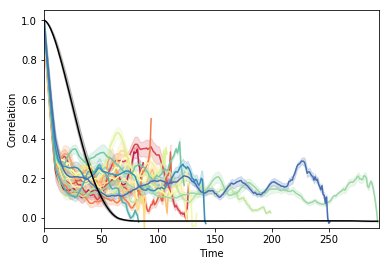

In [744]:
colors = sns.color_palette('Spectral', n_colors=len(recall_models))
max_length = np.max([x.shape[0] for x in recall_models])
for i, r in enumerate(recall_models):
    autocorr_plot(r, color=colors[i], res=False);
autocorr_plot(video_model[0:max_length], color='k', res=False);
plt.ylim([-0.05, 1.05])
plt.xlim([0, max_length])
plt.gcf().savefig(os.path.join(figdir, 'source', 'reinstatement.pdf'))

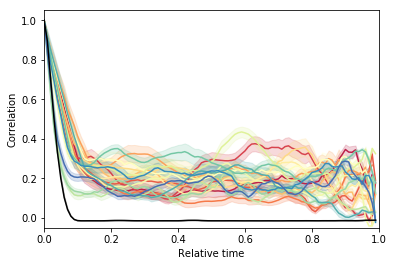

In [745]:
for i, r in enumerate(recall_models):
    autocorr_plot(r, color=colors[i], res=True);
autocorr_plot(video_model, color='k', res=True);
plt.ylim([-0.05, 1.05])
plt.xlim([0, 1])
plt.gcf().savefig(os.path.join(figdir, 'source', 'reinstatement_resampled.pdf'))

In [666]:
def plot_corrmat(c, vmin=0, vmax=1):
    n = c.shape[0]
    ticks = np.linspace(0, n, 5)
    sns.heatmap(c, vmin=vmin, vmax=vmax)
    plt.xlabel('Relative time')
    plt.ylabel('Relative time')
    plt.xticks(ticks, np.divide(ticks, n))
    plt.yticks(ticks, np.divide(ticks, n))

In [29]:
n = 100
recall_corrs = np.zeros([n, n])
all_recall_corrs = []
for i, r in enumerate(recall_models):
    x = resample(pd.DataFrame(r).T.corr(), axis=[0, 1], nbins=n)
    recall_corrs += x
    all_recall_corrs.append(x)
recall_corrs = np.divide(recall_corrs, len(recall_models))

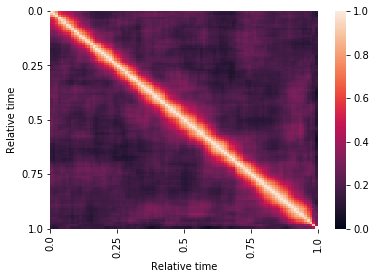

In [30]:
plot_corrmat(recall_corrs)
plt.gcf().savefig(os.path.join(figdir, 'source', 'all_recall_corrs.pdf'))

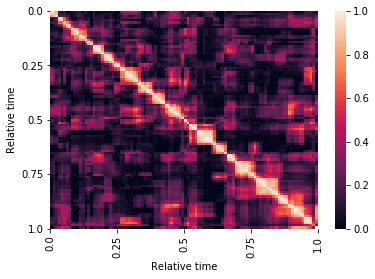

In [31]:
for i, r in enumerate(all_recall_corrs):
    plt.close()
    plot_corrmat(r)
    plt.gcf().savefig(os.path.join(figdir, 'source', f'S{i}_corrs.pdf'))

In [32]:
vid_corrs = resample(pd.DataFrame(video_model).T.corr(), axis=[0, 1], nbins=n)

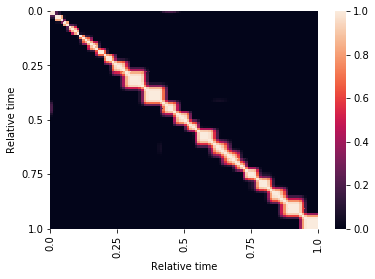

In [33]:
plot_corrmat(vid_corrs)
plt.gcf().savefig(os.path.join(figdir, 'source', 'video_corrs.pdf'))

In [667]:
dtw_files = list(map(lambda x: f's{x}_recall_model_dtw.npy', np.arange(len(recall_models))))
warped_recalls = list(map(lambda f: np.load(os.path.join(datadir, 'processed', f)), dtw_files))

In [668]:
def z2r(z):
    warnings.simplefilter('ignore')
    if isinstance(z, list):
        z = np.array(z)
    r = (np.exp(2 * z) - 1) / (np.exp(2 * z) + 1)
    if isinstance(r, np.ndarray):
        r[np.isinf(z) & (z > 0)] = 1
        r[np.isinf(z) & (z < 0)] = -1
    else:
        if np.isinf(z) & (z > 0):
            return 1
        elif np.isinf(z) & (z < 0):
            return -1
    return r

def r2z(r):
    warnings.simplefilter('ignore')
    return 0.5 * (np.log(1 + r) - np.log(1 - r))

In [669]:
def reinstatement_plot(video, recalls, relative_time, res=False, nbins=101, include_average=True, include_autocorr=True, height=0.1, thresh=None, dist=50):
    if not (type(recalls) is list):
        recalls = [recalls]    
    if res:
        video = resample(video, nbins=nbins).values
        for r in recalls:
            recalls[0] = resample(r, nbins=nbins).values
    ts = np.linspace(0, 1, video.shape[0])
    xlabel = 'Relative time'
    
    if len(recalls) == 1:
        colors = ['k']
    else:
        colors = sns.color_palette('Spectral', n_colors=len(recalls))
    
    x = np.zeros(ts.shape)
    for i, r in enumerate(recalls):
        t = int(np.round(relative_time * (r.shape[0] - 1)))
        next = np.squeeze(1 - cdist(np.atleast_2d(r[t, :]), video, 'correlation'))
        x += r2z(next)
        plt.plot(ts, next, color=colors[i], linewidth=1, alpha=0.4)
    
    y = plt.ylim()
    
    if include_autocorr:
        t = int(np.round(relative_time * video.shape[0] - 1))
        autocorr = np.squeeze(1 - cdist(np.atleast_2d(video[t, :]), video, 'correlation'))                
        lm = localmax(autocorr, height=height, threshold=thresh, distance=dist)[0]
        for m in lm:
            t = ts[m] * video.shape[0]
            p = ts[m]
            print(f'Local video max at t = {t} (prop: {p})')
            #plt.plot([ts[m], ts[m]], [y[0], autocorr[m]], color=[0.5, 0.5, 0.5], linewidth=2)
        plt.plot(ts, autocorr, color=[0.5, 0.5, 0.5], linewidth=2)
    
    if include_average:
        ave = z2r(x / len(recalls))
        plt.plot(ts, ave, color='k', linewidth=2)
        lm = localmax(ave, height=height, threshold=thresh, distance=dist)[0]
        lm_colors = sns.cubehelix_palette(n_colors=len(lm))
        for i, m in enumerate(lm):
            t = ts[m] * video.shape[0]
            p = ts[m]
            print(f'Local recall max at t = {t} (prop: {p})')
            plt.plot(ts[m], ave[m], color=lm_colors[i], marker='o', markeredgecolor='w')
    else:
        lm = []
    
    plt.xlabel(xlabel)
    plt.ylabel('Correlation')
    plt.xlim([np.min(ts), np.max(ts)])
    plt.ylim([-0.05, 1.05])
    
    return lm

Local video max at t = 596.3017721518987 (prop: 0.3017721518987342)
Local video max at t = 651.3296202531646 (prop: 0.329620253164557)
Local recall max at t = 217.10987341772153 (prop: 0.109873417721519)
Local recall max at t = 347.1756962025317 (prop: 0.17569620253164558)
Local recall max at t = 477.2415189873418 (prop: 0.24151898734177216)
Local recall max at t = 570.2886075949368 (prop: 0.2886075949367089)
Local recall max at t = 626.3169620253166 (prop: 0.31696202531645573)
Local recall max at t = 684.3463291139241 (prop: 0.34632911392405064)
Local recall max at t = 751.3802531645571 (prop: 0.38025316455696206)
Local recall max at t = 813.4116455696203 (prop: 0.41164556962025317)
Local recall max at t = 1113.5635443037975 (prop: 0.5635443037974683)
Local recall max at t = 1207.6111392405064 (prop: 0.6111392405063292)
Local recall max at t = 1597.8086075949368 (prop: 0.8086075949367089)


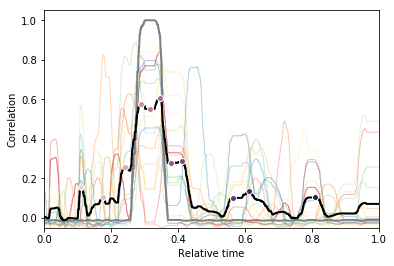

In [670]:
lm = reinstatement_plot(video_model, warped_recalls, 0.328)
#lm = reinstatement_plot(video_model, warped_recalls, 0.8086)
plt.gcf().savefig(os.path.join(figdir, 'source', 'wave_function.pdf'))

## Key to movie times (from `Sherlock_Segments_1000_NN_2017.xlsx`)

In [671]:
annotations = pd.read_excel(os.path.join(datadir, 'raw', 'Sherlock_Segments_1000_NN_2017.xlsx'))
starts = annotations['Start Time (s) ']
ends = annotations['End Time (s) ']
notes = annotations['Scene Details - A Level ']
starts_TR = annotations['Start Time (TRs, 1.5s)']
ends_TR = annotations['End Time (TRs, 1.5s)']

cutpoint = 482 #movie is divided into two clips, and times (in seconds, not TRs) reset when the second clip starts
correction = ends[cutpoint-1]
starts.iloc[cutpoint:] += correction
ends.iloc[cutpoint:] += correction

In [672]:
def btwn(x, a, b):
    return (x >= a) & (x <= b)

def print_annotation(t):
    def print_time(n, x):
        if n >= cutpoint:
            clip = 2
            c = correction
        else:
            clip = 1
            c = 0
        x -= c
        
        minute = int(np.floor(x / 60))
        second = int(x - (60*minute))
        return f'c{clip}_{minute}m{second}s'
        
        
    i = np.where(btwn(t, starts_TR, ends_TR))[0][0]
    print(f'Time: {print_time(i, starts.iloc[i])}--{print_time(i, ends.iloc[i])} (TR: {int(starts_TR.iloc[i])}--{int(ends_TR.iloc[i])}); Description: {notes.iloc[i]}\n')

In [673]:
for m in lm:
    print_annotation(m)

Time: c1_5m22s--c1_5m28s (TR: 216--219); Description: Beth is seen outside in the dark at night having slipped out of the venue. She is next to her car looking for her keys in her bag. She sighs when she can't find them and looks around helplessly. 

Time: c1_8m39s--c1_8m40s (TR: 347--347); Description: John uncomfortably says: "Yeah, I'm not the John Watson…" and never finishes his sentence.

Time: c1_11m53s--c1_11m57s (TR: 476--478); Description: John turns back to Sherlock and says: "We don't know a thing about each other; I don't know where we're meeting; I don't even know your name."

Time: c1_14m13s--c1_14m17s (TR: 570--571); Description: Sherlock trots up the stairs to the first floor landing, then pauses and waits for John.

Time: c1_15m37s--c1_15m41s (TR: 626--627); Description: John looks up at Sherlock and explains: "You said you could identify a software designer by his tie and an airplane pilot by his left thumb."

Time: c1_17m5s--c1_17m7s (TR: 684--685); Description: Mrs.

# Human description of local maxima:
- *Time 5:22 (clip 1) -- 5:28*: victim dying
- *Time 8:39 -- 8:40*: Watson meets with old friend who suggests moving in with a roomate
- *Time 11:53 -- 11:57*: Sherlock and Watson are introduced, Sherlock makes a series of deductions about Watson
- *Time 14:13 -- 14:17*: Sherlock shows Watson his apartment at 221b Baker Street, where they will be living
- *Time 15:37 -- 15:41*: Sherlock and Watson bantering in their apartment, then interrupted by detective who reports new victim [**reference event tagged for recall**]
- *Time 17:05 -- 17:07*: Watson settling into apartment (interaction with land lady)
- *Time 18:42 -- 18:49*: Sherlock smuggly deducing things while Watson looks on with obvious curiosity
- *Time 20:15 -- 20:23*: Flashback to when Sherlock was making deductions about Watson
- *Time 4:09 (clip 2) -- 4:11*: Sherlock making deductions about dead body
- *Time 6:30 -- 6:31*: Sherlock making deductions about dead body
- *Time 16:13 -- 16:18*: Mysterious man warns Watson away from Sherlock

# Free recall analyses

In [1101]:
def grouped_mean(vals, groups, axis, res=False, nbins=100):
    unique_groups = np.unique(groups)
    summary = []
    for g in unique_groups:
        x = pd.DataFrame(np.nanmean(np.take(vals.values, np.where(groups == g)[0], axis=axis), axis=axis))
        if res:
            x = resample(end_crop(x), axis=1, nbins=nbins)
        summary.append(x)
    if res:
        cs = np.linspace(0, 1, nbins)
    else:
        cs = np.linspace(0, 1, vals.shape[1])
    return pd.DataFrame(safecat(summary, axis=1).T, columns=cs, index=unique_groups)

def isnan(x):
    inds = np.zeros(x.shape)
    for i in np.arange(x.shape[0]):
        inds[i, :] = list(map(np.isscalar, rec_words[i]))        
    return np.array(inds, dtype=bool)

def reinstatement_figure(egg, outfile=None, n=100):    
    def fr_corrmat(topics):
        good_inds = np.sum(topics > (1/topics.shape[2]), axis=2) < topics.shape[2]    
        return list(map(lambda x, i: pd.DataFrame(x[i, :]).T.corr().values, np.split(topics, topics.shape[0]), np.split(good_inds, topics.shape[0])))
    
    def get_fr_autocorrs(corrmats):
        x = []
        good_inds = []
        for i in np.arange(len(corrmats)):
            if len(corrmats[i]) == 0:
                continue
            else:
                next_x = autocorr_plot(corrmats[i].values, show_plot=False, pass_matrix=True)
            if type(x) is list:
                x = pd.DataFrame(next_x.mean(axis=0)).T
            else:
                x = pd.concat([x, pd.DataFrame(next_x.mean(axis=0)).T], axis=0)
            good_inds.append(i)
        return x, good_inds
    
    pres_words = egg.get_pres_items().values
    rec_words = egg.get_rec_items().values    
    rec_words[isnan(rec_words)] = ''
    
    pres_topics = np.array(hyp.tools.format_data(np.split(pres_words, pres_words.shape[0])))
    rec_topics = np.array(hyp.tools.format_data(np.split(rec_words, rec_words.shape[0])))
    
    pres_corrmats = fr_corrmat(pres_topics)
    rec_corrmats = fr_corrmat(rec_topics)
    
    #resample rec_corrmats to be the same size as pres_corrmats and match up the indices/columns
    for i in np.arange(len(rec_corrmats)):
        ts = np.linspace(0, 1, n)
        pres_corrmats[i] = resample(pres_corrmats[i], axis=[0, 1], nbins=n)
        if len(rec_corrmats[i]) == 0:
            continue
        elif len(rec_corrmats[i]) == 1:
            rec_corrmats[i] = pd.DataFrame(np.nan * np.zeros([n, n]), index=ts, columns=ts)
        else:
            rec_corrmats[i] = resample(rec_corrmats[i], axis=[0, 1], nbins=n)  
    
    pres_autocorrs, pres_inds = get_fr_autocorrs(pres_corrmats)
    rec_autocorrs, rec_inds = get_fr_autocorrs(rec_corrmats)
    
    idx = egg.get_pres_items().index
    subjs = idx.levels[0][idx.labels[0]]
    lists = idx.levels[1][idx.labels[1]]
    
    #resample rec_corrmats to be the same size as pres_corrmats and match up the indices/columns
    n = 101 #pres_corrmats[i].shape[0]
    for i in np.arange(len(rec_corrmats)):
        ts = np.linspace(0, 1, n)
        pres_corrmats[i] = resample(pres_corrmats[i], axis=[0, 1], nbins=n)
        if len(rec_corrmats[i]) == 0:
            continue
        elif len(rec_corrmats[i]) == 1:
            rec_corrmats[i] = pd.DataFrame(np.nan * np.zeros([n, n]), index=ts, columns=ts)
        else:
            rec_corrmats[i] = resample(rec_corrmats[i], axis=[0, 1], nbins=n)    
    
    unique_subjs = np.unique(subjs[rec_inds])
    colors = sns.color_palette('Spectral', n_colors=len(unique_subjs))

    ts = np.linspace(0, 1, rec_autocorrs.shape[1])
    for i, s in enumerate(unique_subjs):
        plot_ribbon(pd.DataFrame(rec_autocorrs.iloc[np.where(subjs[rec_inds] == s)[0], :].values, columns=ts), color=colors[i])
    plot_ribbon(grouped_mean(pres_autocorrs, subjs[pres_inds], axis=0), color='k');
    plt.xlim([0, 1])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Relative time')
    plt.ylabel('Correlation');
    if not outfile is None:
        plt.gcf().savefig(os.path.join(figdir, 'source', outfile))
    
    return pres_autocorrs, pres_inds, rec_autocorrs, rec_inds, subjs

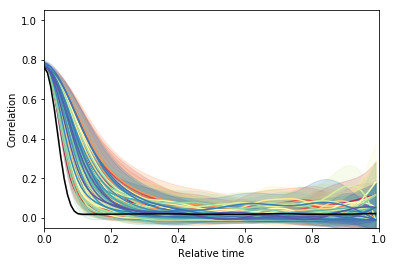

In [1084]:
pres_rand, pres_rand_inds, rec_rand, rec_rand_inds, subjs_rand = reinstatement_figure(fr_random_data, 'fr_random_reinstatement.pdf')

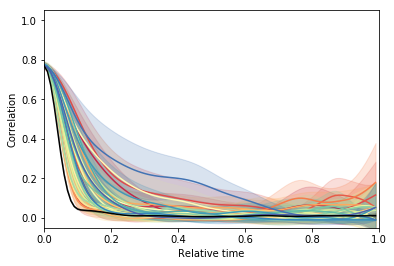

In [1085]:
pres_cat, pres_cat_inds, rec_cat, rec_cat_inds, subjs_cat = reinstatement_figure(fr_cat_data, 'fr_category_reinstatement.pdf')

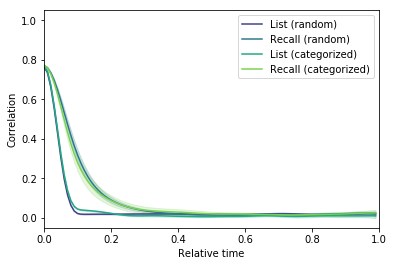

In [1092]:
colors = sns.color_palette('viridis', n_colors=4)

#random
plot_ribbon(grouped_mean(pres_rand, subjs_rand[pres_rand_inds], axis=0), color=colors[0])
plot_ribbon(grouped_mean(rec_rand, subjs_rand[rec_rand_inds], axis=0), color=colors[1])

#category
plot_ribbon(grouped_mean(pres_cat, subjs_cat[pres_cat_inds], axis=0), color=colors[2])
plot_ribbon(grouped_mean(rec_cat, subjs_cat[rec_cat_inds], axis=0), color=colors[3])
plt.legend(['List (random)', 'Recall (random)', 'List (categorized)', 'Recall (categorized)'])
plt.xlabel('Relative time')
plt.ylabel('Correlation')
plt.xlim([0, 1])
plt.ylim([-0.05, 1.05])
plt.gcf().savefig(os.path.join(figdir, 'source', 'list_recall_reinstatement_means.pdf'))

In [1248]:
def fr_reinstatement_plot(egg, subj_ind, list_ind, n_recalls):
    pres_words = egg.get_pres_items().values
    rec_words = egg.get_rec_items().values    
    rec_words[isnan(rec_words)] = ''
    
    pres_topics = np.array(hyp.tools.format_data(np.split(pres_words, pres_words.shape[0])))
    rec_topics = np.array(hyp.tools.format_data(np.split(rec_words, rec_words.shape[0])))
    
    idx = egg.get_pres_items().index
    subjs = idx.levels[0][idx.labels[0]]
    lists = idx.levels[1][idx.labels[1]]
    
    unique_subjs = np.unique(subjs)
    unique_lists = np.unique(lists)
    
    ind = np.where((subjs == unique_subjs[subj_ind]) & (lists == unique_lists[list_ind]))[0]
    if len(ind) == 0:
        return
    ind = ind[0]
    
    p = np.squeeze(pres_topics[ind, :, :])
    r = np.squeeze(rec_topics[ind, :, :])    
    good_inds = np.sum(r > 1.0 / r.shape[1], axis=1) < r.shape[1]
    r = r[good_inds, :]
    
    n_recalls = np.min([n_recalls, r.shape[0]])
    
    corrs = resample(1 - cdist(p, r[:n_recalls, :], 'correlation'), axis=[0], nbins=200).T
    colors = sns.cubehelix_palette(n_colors=n_recalls)
    
    ax = plt.subplot(111)
    
    for i in np.arange(n_recalls):
        ax.plot(corrs.iloc[i, :], color=colors[i])
    plt.xlabel('Relative presentation time')
    plt.ylabel('Correlation')
    plt.xlim([0, 1])
    plt.ylim([-0.05, 1.05])
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.75, box.height])        
    ax.legend(np.arange(n_recalls)+1, loc='upper', bbox_to_anchor=(1.05, 0.7), ncol=2, title='Recall output position', edgecolor=None, framealpha=0)

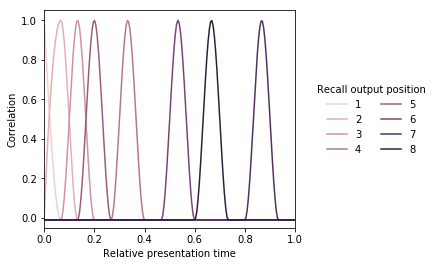

In [1249]:
fr_reinstatement_plot(fr_random_data, 3, 1, 30)
plt.gcf().savefig(os.path.join(figdir, 'source', 'fr_reinstatement_ordered.pdf'))

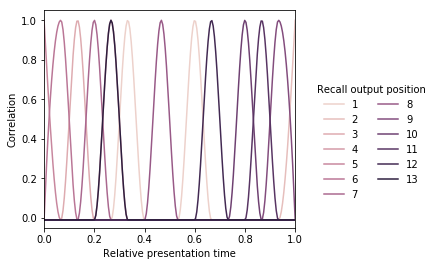

In [1251]:
fr_reinstatement_plot(fr_random_data, 10, 2, 30)
plt.gcf().savefig(os.path.join(figdir, 'source', 'fr_reinstatement_unordered.pdf'))

In [1061]:
def safecat(xs, axis=0, min_dims=2):
    ndims = np.max([np.max(list(map(np.ndim, xs))), axis+1, min_dims])
    
    for i, x in enumerate(xs):
        x_dim = np.ndim(x)
        if x_dim < ndims:
            for j in np.arange(ndims - x_dim):
                xs[i] = np.copy(np.expand_dims(x, j + x_dim))    
    
    shapes = list(map(np.shape, xs))
    target_shape = np.max(np.vstack(shapes), axis=0)
    pre_padding = np.zeros(ndims, dtype=int)
    
    for i, x in enumerate(xs):
        x_padding = np.array(target_shape - shapes[i], dtype=int)
        x_padding[axis] = 0
        xs[i] = np.pad(x, list(zip(pre_padding, x_padding)), 'constant', constant_values=np.nan)
    
    return np.concatenate(xs, axis=axis)